# Preparation
### Setup your own variables

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0) # which gpu
workplace = os.path.join(os.environ["HOME"], "mixmo-pytorch") # where is your code
checkpointplace = os.path.join(os.environ["HOME"], "checkpoints") # where are your checkpoints
dataplace = "/data" # parent folder where is your cifar-100 dataset

### Import standard librairies and mixmo

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import torch

import sys
sys.path.append(workplace)
from mixmo.loaders import get_loader
from mixmo.learners.learner import Learner
from mixmo.utils import (misc, visualize)

# Load pretrained networks

## Set configuration

CIFAR-100 dataset with:
- WideResNet-28-10 network architecture
- `M=2` subnetworks
- Cut-MixMo mixing block (patch mixing) with probability `p=0.5`
- CutMix mixed sample data augmentation
- batch repetition to `b=4`

In [3]:
config_name = "cifar100_wrn2810-2_cutmixmo-p5_msdacutmix_bar4"

In [4]:
# path to the config describing the dataset, the learning strategy and the network 
config_path = os.path.join(
    workplace,
    "config/cifar100/exp_"+ config_name + ".yaml"
)
config_args = misc.load_config_yaml(config_path)
# additional arguments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tempscale = False
corruptions = False

[Checkpoint](https://drive.google.com/file/d/1fwCfO2wO6VXziUp9HHE32MpCWak9AlOc/view?usp=sharing) to be downloaded in folder `checkpointplace`

In [5]:
# path to the pretrained checkpoint
checkpoint = os.path.join(checkpointplace, "checkpoint_"+ config_name + ".ckpt")

In [6]:
# additional arguments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tempscale = False
corruptions = False

## Load dataset

We load the dataset through a dloader object that takes care of the data loading, augmentation and input formatting steps

In [7]:
dloader = get_loader(
    config_args, split_test_val=tempscale, dataplace=dataplace, corruptions=corruptions
)

Files already downloaded and verified
Files already downloaded and verified


2021-04-07 12:29:54,777 pascal mixmo.loaders.abstract_loader[3935634] WARNING No validation loader


## Load learner

We now build the learner object that wraps both the model, optimizer and the already built loader objects. Training is performed through methods of this learner object.

In [8]:
learner = Learner(
    config_args=config_args,
    dloader=dloader,
    device=device,
)

2021-04-07 12:29:54,784 pascal mixmo.networks[3935634] WARNING Loading network: wideresnetmixmo
2021-04-07 12:30:08,154 pascal mixmo.networks.resnet[3935634] WARNING Features dimension: 640
2021-04-07 12:30:10,753 pascal mixmo.core.loss[3935634] INFO Using loss: {'name': 'soft_cross_entropy', 'display_name': 'ce0', 'coeff': 1, 'input': 'logits_0', 'target': 'target_0'} with name: ce0
2021-04-07 12:30:10,755 pascal mixmo.core.loss[3935634] INFO Using loss: {'name': 'soft_cross_entropy', 'display_name': 'ce1', 'coeff': 1.0, 'input': 'logits_1', 'target': 'target_1'} with name: ce1
2021-04-07 12:30:10,755 pascal mixmo.core.loss[3935634] DEBUG Skip loss: {'name': 'soft_cross_entropy', 'display_name': 'ce2', 'coeff': 0, 'input': 'logits_2', 'target': 'target_2'}
2021-04-07 12:30:10,756 pascal mixmo.core.loss[3935634] WARNING Set l2 regularization on WideResNetMixMo
2021-04-07 12:30:10,757 pascal mixmo.core.optimizer[3935634] INFO Using optimizer sgd with params {'lr': 0.0125, 'momentum': 0.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 16, 32, 32]             432
            Conv2d-2            [2, 16, 32, 32]             432
       BatchNorm2d-3            [2, 16, 32, 32]              32
            Conv2d-4           [2, 160, 32, 32]          23,040
       BatchNorm2d-5           [2, 160, 32, 32]             320
            Conv2d-6           [2, 160, 32, 32]         230,400
            Conv2d-7           [2, 160, 32, 32]           2,560
         WideBasic-8           [2, 160, 32, 32]               0
       BatchNorm2d-9           [2, 160, 32, 32]             320
           Conv2d-10           [2, 160, 32, 32]         230,400
      BatchNorm2d-11           [2, 160, 32, 32]             320
           Conv2d-12           [2, 160, 32, 32]         230,400
        WideBasic-13           [2, 160, 32, 32]               0
      BatchNorm2d-14           [2, 160,

## Load checkpoint

In [9]:
learner.load_checkpoint(checkpoint, include_optimizer=False)

# Model evaluation

Model evaluation is generally done by the learner object as shown at the end of this notebook. It is nevertheless possible to break down the process explicitly.

## Batch by batch

The dataloader object can be retrieved from the loader, though objects returned by the dataloader follow a specific formatting convention.

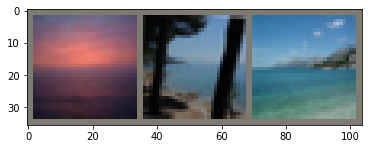

In [10]:
data = next(iter(learner.dloader.test_loader))
dict_tensors = learner._prepare_batch_test(data)
class_id = 71
pixels_filtered = dict_tensors["pixels"].cpu()[
    dict_tensors["target"]["target_0"] == class_id, :3]
_ = visualize.show_batch(pixels_filtered)

After some slight reformatting (normally performed by the learner internally) we can feed the batch to the network and retrieve logits for the batch.

In [11]:
output = learner.model_wrapper.network(
    {
        "pixels": pixels_filtered.to(device),
        "metadata": dict_tensors["metadata"]
    }
)
print(output["logits"].max(dim=1))

torch.return_types.max(
values=tensor([10.4478,  6.4189, 12.4999], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([71, 59, 71], device='cuda:0'))


## Predict on the full test set using the learner

In [12]:
scores = learner.evaluate(
    inference_loader=dloader.test_loader,
    split="final",
)
misc.print_dict(scores)

Evaluation: 100%|██████████| 157/157 [00:09<00:00, 16.47it/s]
2021-04-07 12:30:21,105 pascal mixmo.learners.model_wrapper[3935634] INFO Compute metrics for classifier at split: final



########################################
final/accuracy               85.92%
final/accuracy_0             84.29%
final/accuracy_1             83.88%
final/accuracy_mean          84.08%
final/accuracytop5           97.36%
final/auc                    0.9
final/brier                  0.00205044
final/ce0                    0.58707
final/ce1                    0.60689
final/diversity_ratioerrors  0.86241
final/ece                    0.0228678
final/main                   2.2717
final/nll                    0.518282
general/l2_reg               3.592e+03
########################################

